# OI Risk Preliminaries

## Executive Summary

This notebook establishes the foundational understanding of the cryptocurrency derivatives risk framework by exploring available data and developing robust statistical measures of volatility and liquidity. These metrics will drive the **Open Interest (OI)** limit and **Price Band** mechanisms developed in subsequent notebooks.

The analysis centers on a fundamental principle: **the cost to manipulate spot markets must exceed the potential profit from derivative positions**. By quantifying both volatility (measuring how much prices move) and liquidity (measuring how much capital is required to move prices), we can operationalize this principle into estimating concrete risk parameters that protect the vault from insolvency while maintaining competitive market conditions.

## 1. Data Preprocessing

### Data Sources

- **Mark Price Data** (`data/mark_price/`) contains 1-minute OHLC (Open, High, Low, Close) data.
- **Index Price Data** (`data/index_price/`) contains 1-minute OHLC data.
- **Last Price Data** (`data/klines/`) contains 1-minute OHLCV (Open, High, Low, Close, Volume) data.

### Capabilities

Since we only have 1-minute OHLCV data, not high-frequency tick data or order book snapshots, there are some restrictions on what we can do and cannot do.
- **Impossible**
    - We cannot directly measure order book depth at specific price levels, which would require order book snapshots showing bid and ask quantities at each price point.
    - We cannot detect millisecond-level spoofing or quote stuffing, which requires tick-by-tick order data.
    - We cannot calculate precise slippage from order book data, which would require reconstructing the full limit order book and simulating order execution.

- **Possible Workaroun**
    - We can construct robust statistical proxies for volatility using range-based estimators (Parkinson, Garman-Klass) that have been validated over decades of academic research.
    - We can measure effective liquidity through the Amihud Illiquidity Ratio, which relates price impact to trading volume and has been shown to correlate strongly with true market depth.
    - We can detect macroscopic solvency threats such as sustained illiquidity, extreme volatility regimes, and flash crashes that occur over minute-to-hour timescales.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.linear_model import LinearRegression
import warnings
from pathlib import Path

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:.6f}')
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Define constants
SYMBOLS = ['BTCUSDT', 'ETHUSDT', "SUIUSDT", "DOGEUSDT", "AXSUSDT"]
DATA_DIR = Path('../../data')
MARK_PRICE_DIR = DATA_DIR / 'mark_price'
INDEX_PRICE_DIR = DATA_DIR / 'index_price'
KLINES_DIR = DATA_DIR / 'klines'

def calculate_subplot_grid(n_plots):
    """
    Calculate optimal grid layout (nrows, ncols) for n_plots.
    Returns a grid that minimizes empty subplots while keeping aspect ratio reasonable.
    """
    if n_plots == 0:
        return 1, 1
    elif n_plots == 1:
        return 1, 1
    elif n_plots == 2:
        return 1, 2
    elif n_plots <= 4:
        return 2, 2
    elif n_plots <= 6:
        return 3, 2
    elif n_plots <= 8:
        return 4, 2
    else:
        # For larger numbers, aim for roughly square grid
        ncols = 2
        nrows = int(np.ceil(n_plots / ncols))
        return nrows, ncols

print("Environment initialized successfully")
print(f"Analyzing {len(SYMBOLS)} symbols: {', '.join(SYMBOLS)}")

Environment initialized successfully
Analyzing 5 symbols: BTCUSDT, ETHUSDT, SUIUSDT, DOGEUSDT, AXSUSDT


### Data Loading Functions

In [2]:
def load_mark_price(symbol):
    """Load mark price OHLC data for a symbol."""
    filepath = MARK_PRICE_DIR / f"{symbol}_1m.csv"
    df = pd.read_csv(filepath)
    df['open_time'] = pd.to_datetime(df['open_time'])
    df.set_index('open_time', inplace=True)
    df['symbol'] = symbol
    return df

def load_index_price(symbol):
    """Load index price OHLC data for a symbol."""
    filepath = INDEX_PRICE_DIR / f"{symbol}_1m.csv"
    df = pd.read_csv(filepath)
    df['open_time'] = pd.to_datetime(df['open_time'])
    df.set_index('open_time', inplace=True)
    df['symbol'] = symbol
    return df

def load_klines(symbol):
    """Load klines (last price) OHLCV data for a symbol."""
    filepath = KLINES_DIR / f"{symbol}_1m.csv"
    df = pd.read_csv(filepath)
    df['open_time'] = pd.to_datetime(df['open_time'])
    df.set_index('open_time', inplace=True)
    df['symbol'] = symbol
    # Keep relevant columns
    cols_to_keep = ['open', 'high', 'low', 'close', 'volume', 'quote_volume', 'trades', 
                    'taker_buy_base', 'taker_buy_quote', 'symbol']
    df = df[[col for col in cols_to_keep if col in df.columns]]
    return df

def load_all_data(symbols):
    """Load all three data sources for all symbols."""
    mark_data = {}
    index_data = {}
    klines_data = {}
    
    for symbol in symbols:
        try:
            mark_data[symbol] = load_mark_price(symbol)
            index_data[symbol] = load_index_price(symbol)
            klines_data[symbol] = load_klines(symbol)
            print(f"✓ Loaded {symbol}: {len(klines_data[symbol])} records")
        except FileNotFoundError as e:
            print(f"✗ Missing data for {symbol}: {e}")
    
    return mark_data, index_data, klines_data

# Load all data
mark_prices, index_prices, klines = load_all_data(SYMBOLS)

✓ Loaded BTCUSDT: 3156481 records
✓ Loaded ETHUSDT: 3156481 records
✓ Loaded SUIUSDT: 1401601 records
✓ Loaded DOGEUSDT: 2880901 records
✓ Loaded AXSUSDT: 2689497 records


### Data Quality Assessment

In [3]:
from IPython.display import HTML, display

def assess_data_quality(data_dict, data_type):
    """Assess data quality for a given data source."""
    quality_report = []
    
    for symbol, df in data_dict.items():
        report = {
            'Symbol': symbol,
            'Data Type': data_type,
            'Total Records': len(df),
            'Start Date': df.index.min(),
            'End Date': df.index.max(),
            'Duration (days)': (df.index.max() - df.index.min()).days,
            'Missing Values': df.isnull().sum().sum(),
            'Missing %': f"{df.isnull().sum().sum() / (len(df) * len(df.columns)) * 100:.2f}%"
        }
        
        # Check for temporal gaps (missing minutes)
        expected_records = (df.index.max() - df.index.min()).total_seconds() / 60 + 1
        gap_pct = (1 - len(df) / expected_records) * 100
        report['Temporal Gaps %'] = f"{gap_pct:.2f}%"
        
        quality_report.append(report)
    
    return pd.DataFrame(quality_report)

# Generate quality reports

display(HTML('<h4 style="text-align: center; margin-top: 15px; margin-bottom: 5px; font-weight: bold;">Mark Price Data</h4>'))
mark_quality = assess_data_quality(mark_prices, 'Mark Price')
display(mark_quality)

display(HTML('<h4 style="text-align: center; margin-top: 15px; margin-bottom: 5px; font-weight: bold;">Index Price Data</h4>'))
index_quality = assess_data_quality(index_prices, 'Index Price')
display(index_quality)

display(HTML('<h4 style="text-align: center; margin-top: 15px; margin-bottom: 5px; font-weight: bold;">Klines (Last Price) Data</h4>'))
klines_quality = assess_data_quality(klines, 'Klines')
display(klines_quality)

,Symbol,Data Type,Total Records,Start Date,End Date,Duration (days),Missing Values,Missing %,Temporal Gaps %
0,BTCUSDT,Mark Price,3156426,2020-01-01 00:00:00,2026-01-01,2192,0,0.00%,0.00%
1,ETHUSDT,Mark Price,3156415,2020-01-01 00:00:00,2026-01-01,2192,0,0.00%,0.00%
2,SUIUSDT,Mark Price,1401807,2023-05-03 12:32:00,2026-01-01,973,0,0.00%,0.00%
3,DOGEUSDT,Mark Price,2881225,2020-07-10 03:05:00,2026-01-01,2000,0,0.00%,0.00%
4,AXSUSDT,Mark Price,2689676,2020-11-20 03:34:00,2026-01-01,1867,0,0.00%,0.00%


,Symbol,Data Type,Total Records,Start Date,End Date,Duration (days),Missing Values,Missing %,Temporal Gaps %
0,BTCUSDT,Index Price,3156421,2020-01-01 00:00:00,2026-01-01,2192,0,0.00%,0.00%
1,ETHUSDT,Index Price,3156420,2020-01-01 00:00:00,2026-01-01,2192,0,0.00%,0.00%
2,SUIUSDT,Index Price,1401807,2023-05-03 12:32:00,2026-01-01,973,0,0.00%,0.00%
3,DOGEUSDT,Index Price,2883915,2020-07-08 06:19:00,2026-01-01,2002,0,0.00%,0.00%
4,AXSUSDT,Index Price,2703778,2020-11-10 08:37:00,2026-01-01,1877,0,0.00%,0.00%


,Symbol,Data Type,Total Records,Start Date,End Date,Duration (days),Missing Values,Missing %,Temporal Gaps %
0,BTCUSDT,Klines,3156481,2020-01-01 00:00:00,2026-01-01,2192,0,0.00%,0.00%
1,ETHUSDT,Klines,3156481,2020-01-01 00:00:00,2026-01-01,2192,0,0.00%,0.00%
2,SUIUSDT,Klines,1401601,2023-05-03 16:00:00,2026-01-01,973,0,0.00%,0.00%
3,DOGEUSDT,Klines,2880901,2020-07-10 09:00:00,2026-01-01,2000,0,0.00%,0.00%
4,AXSUSDT,Klines,2689497,2020-11-20 07:04:00,2026-01-01,1867,0,0.00%,0.00%


## 2. Data Summary

### Price Vector Deviation Relationships

In [4]:
def analyze_price_relationships(symbol):
    """Analyze relationships between Last, Mark, and Index prices."""
    # Align data on common timestamps
    last = klines[symbol]['close'].rename('Last')
    mark = mark_prices[symbol]['close'].rename('Mark')
    index = index_prices[symbol]['close'].rename('Index')
    
    # Combine into single DataFrame
    prices = pd.concat([last, mark, index], axis=1).dropna()
    
    # Calculate deviations
    prices['Mark_Index_Basis_bps'] = (prices['Mark'] - prices['Index']) / prices['Index'] * 10000
    prices['Last_Mark_Deviation_bps'] = (prices['Last'] - prices['Mark']) / prices['Mark'] * 10000
    
    return prices

# Analyze price relationships for all symbols
price_relationships = {}
for symbol in SYMBOLS:
    if symbol in klines and symbol in mark_prices and symbol in index_prices:
        price_relationships[symbol] = analyze_price_relationships(symbol)

# Summary statistics
for symbol in SYMBOLS:
    if symbol in price_relationships:
        pr = price_relationships[symbol]
        print(f"\n{symbol}:")
        print(f"  Mark-Index Basis: μ={pr['Mark_Index_Basis_bps'].mean():.2f} bps, "
              f"σ={pr['Mark_Index_Basis_bps'].std():.2f} bps")
        print(f"  Last-Mark Deviation: μ={pr['Last_Mark_Deviation_bps'].mean():.2f} bps, "
              f"σ={pr['Last_Mark_Deviation_bps'].std():.2f} bps")
        print(f"  Correlation (Last-Mark): {pr['Last'].corr(pr['Mark']):.6f}")
        print(f"  Correlation (Mark-Index): {pr['Mark'].corr(pr['Index']):.6f}")


BTCUSDT:
  Mark-Index Basis: μ=-0.79 bps, σ=5.18 bps
  Last-Mark Deviation: μ=-0.13 bps, σ=3.42 bps
  Correlation (Last-Mark): 1.000000
  Correlation (Mark-Index): 1.000000

ETHUSDT:
  Mark-Index Basis: μ=-0.33 bps, σ=6.34 bps
  Last-Mark Deviation: μ=0.16 bps, σ=3.95 bps
  Correlation (Last-Mark): 1.000000
  Correlation (Mark-Index): 0.999999

SUIUSDT:
  Mark-Index Basis: μ=-2.02 bps, σ=5.89 bps
  Last-Mark Deviation: μ=-0.46 bps, σ=3.50 bps
  Correlation (Last-Mark): 1.000000
  Correlation (Mark-Index): 1.000000

DOGEUSDT:
  Mark-Index Basis: μ=-0.50 bps, σ=8.91 bps
  Last-Mark Deviation: μ=-0.29 bps, σ=5.53 bps
  Correlation (Last-Mark): 1.000000
  Correlation (Mark-Index): 0.999999

AXSUSDT:
  Mark-Index Basis: μ=-5.24 bps, σ=14.98 bps
  Last-Mark Deviation: μ=-0.89 bps, σ=6.56 bps
  Correlation (Last-Mark): 1.000000
  Correlation (Mark-Index): 0.999999


### Volume Characteristics

In [5]:
# Volume statistics
volume_stats = []
for symbol in SYMBOLS:
    if symbol in klines:
        vol = klines[symbol]['volume'] * klines[symbol]['close'] # Volume in $
        stats_dict = {
            'Symbol': symbol,
            'Mean Volume': vol.mean(),
            'Median Volume': vol.median(),
            'P95 Volume': vol.quantile(0.95),
            'Max Volume': vol.max(),
            'Zero Volume %': (vol == 0).sum() / len(vol) * 100,
            'Daily Volume (avg)': vol.resample('D').sum().mean()
        }
        volume_stats.append(stats_dict)

volume_df = pd.DataFrame(volume_stats)

# Format the DataFrame for display
volume_df_display = volume_df.copy()
for col in ['Mean Volume', 'Median Volume', 'P95 Volume', 'Max Volume', 'Daily Volume (avg)']:
    volume_df_display[col] = volume_df_display[col].apply(lambda x: f'{x:,.2f}')
volume_df_display['Zero Volume %'] = volume_df_display['Zero Volume %'].apply(lambda x: f'{x:.4f}')

display(volume_df_display)


,Symbol,Mean Volume,Median Volume,P95 Volume,Max Volume,Zero Volume %,Daily Volume (avg)
0,BTCUSDT,"9,206,457.73","4,490,029.47","31,872,627.72","1,426,684,556.81",0.0058,"13,251,258,053.02"
1,ETHUSDT,"5,276,300.94","2,422,625.38","18,744,489.01","1,090,337,543.24",0.0067,"7,594,411,154.33"
2,SUIUSDT,"385,557.78","183,599.54","1,360,765.02","65,427,111.51",0.0046,"554,254,536.48"
3,DOGEUSDT,"715,250.32","222,767.94","2,792,952.10","164,326,116.69",0.4904,"1,029,253,423.20"
4,AXSUSDT,"136,116.76","24,929.50","508,273.68","87,342,980.46",0.0339,"195,872,452.25"


### Daily Volume Distribution

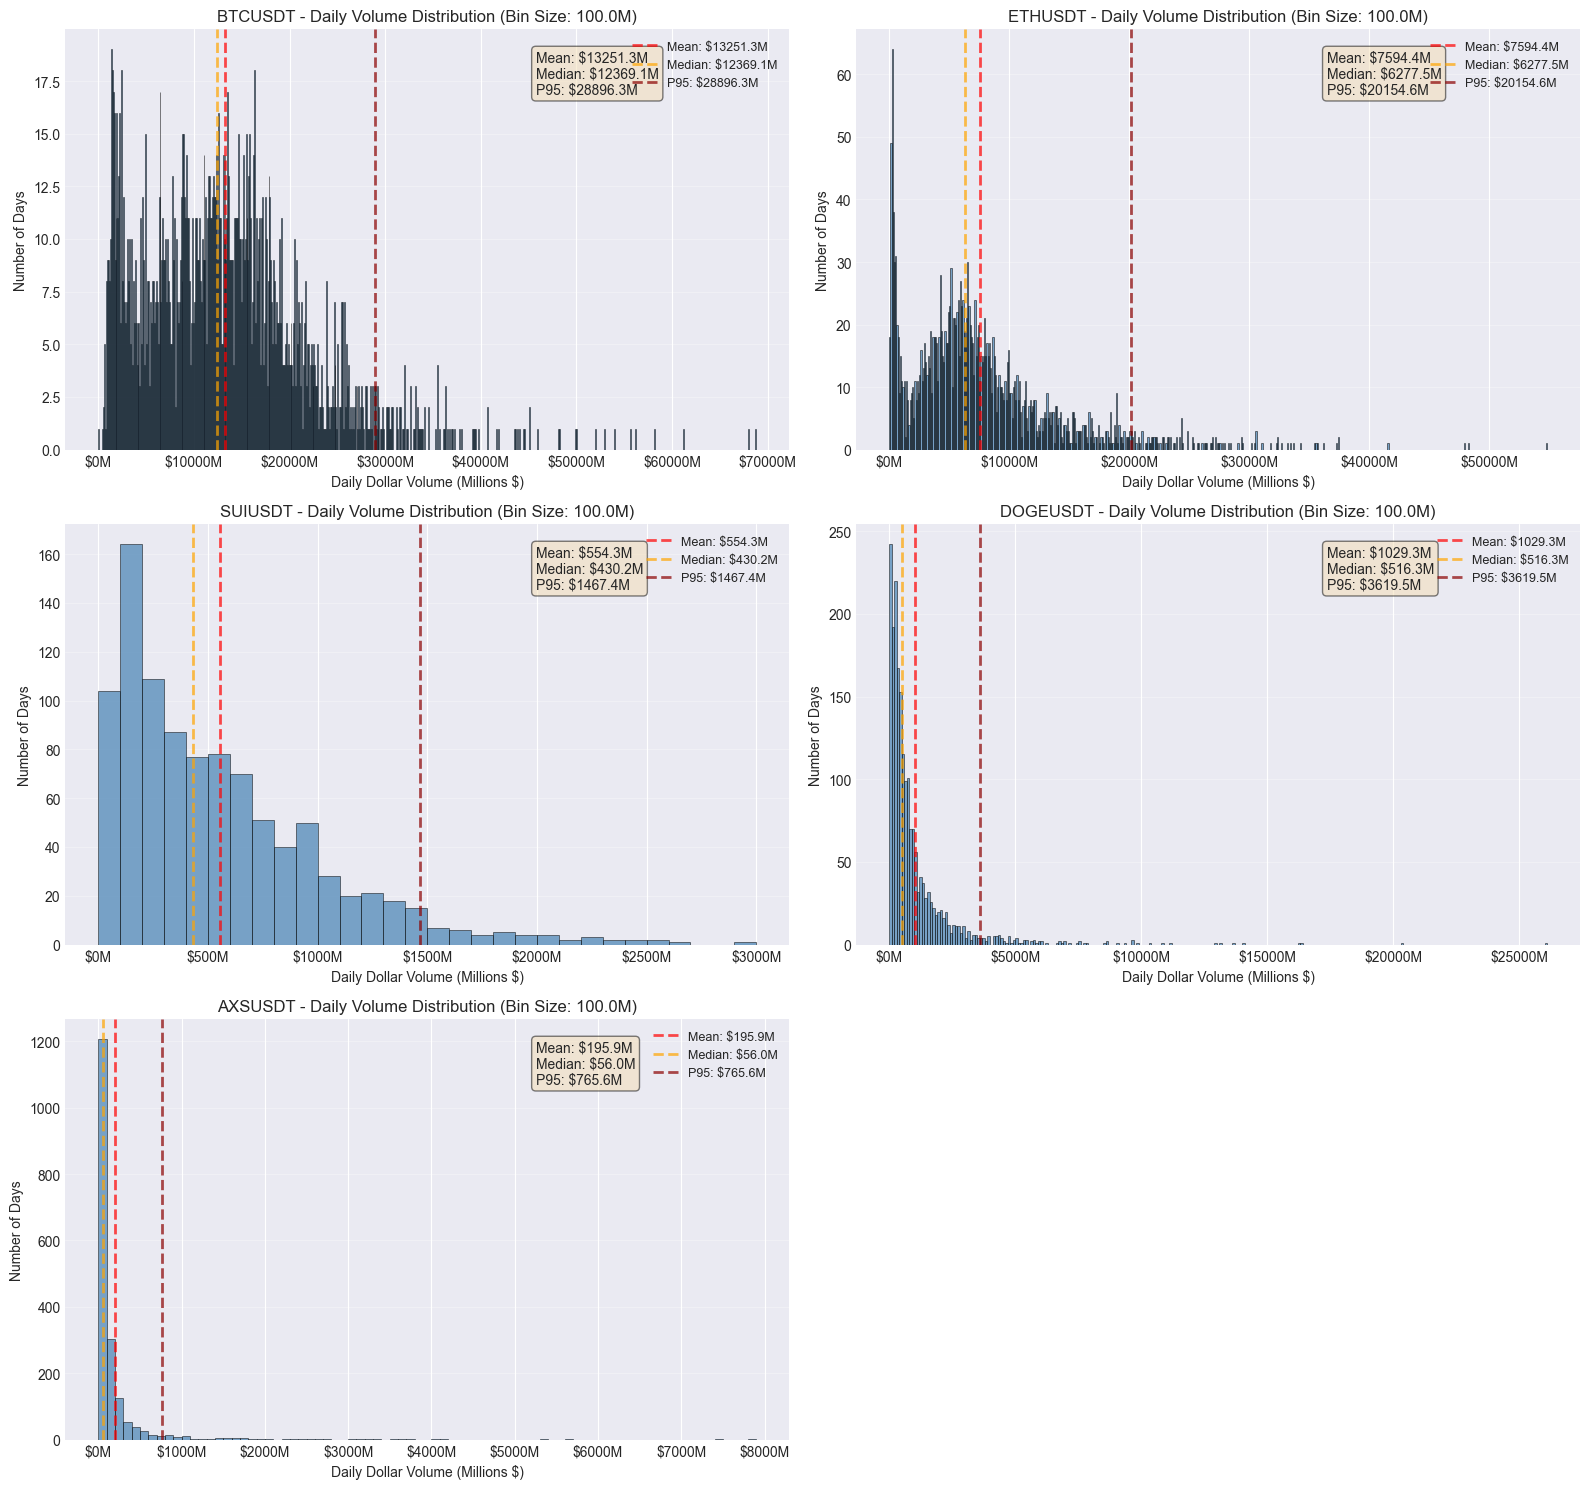

In [6]:
# Calculate daily dollar volume for each symbol
daily_volumes = {}
for symbol in SYMBOLS:
    if symbol in klines:
        df = klines[symbol].copy()
        df['dollar_volume'] = df['volume'] * df['close']
        daily_vol = df['dollar_volume'].resample('D').sum()
        daily_volumes[symbol] = daily_vol

# Create histogram visualization
symbols_with_data = [s for s in SYMBOLS if s in daily_volumes]
n_symbols = len(symbols_with_data)
nrows, ncols = calculate_subplot_grid(n_symbols)

fig, axes = plt.subplots(nrows, ncols, figsize=(8*ncols, 5*nrows))

# Handle both single subplot and multiple subplots
if n_symbols == 1:
    axes = [axes]
else:
    axes = axes.flatten() if n_symbols > 1 else [axes]

# Define bin size: $5M per bucket
bin_size = 100_000_000

for idx, symbol in enumerate(symbols_with_data):
    ax = axes[idx]
    daily_vol = daily_volumes[symbol].dropna()
    
    # Calculate bin edges
    max_vol = daily_vol.max()
    bins = np.arange(0, max_vol + bin_size, bin_size)
    
    # Create histogram
    counts, edges, patches = ax.hist(daily_vol, bins=bins, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)
    
    # Add statistics as text
    mean_vol = daily_vol.mean()
    median_vol = daily_vol.median()
    p95_vol = daily_vol.quantile(0.95)
    
    stats_text = f'Mean: ${mean_vol/1e6:.1f}M\nMedian: ${median_vol/1e6:.1f}M\nP95: ${p95_vol/1e6:.1f}M'
    ax.text(0.65, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Add vertical lines for key statistics
    ax.axvline(mean_vol, color='red', linestyle='--', linewidth=2, label=f'Mean: ${mean_vol/1e6:.1f}M', alpha=0.7)
    ax.axvline(median_vol, color='orange', linestyle='--', linewidth=2, label=f'Median: ${median_vol/1e6:.1f}M', alpha=0.7)
    ax.axvline(p95_vol, color='darkred', linestyle='--', linewidth=2, label=f'P95: ${p95_vol/1e6:.1f}M', alpha=0.7)
    
    # Format x-axis in millions
    ax.set_xlabel('Daily Dollar Volume (Millions $)')
    ax.set_ylabel('Number of Days')
    ax.set_title(f'{symbol} - Daily Volume Distribution (Bin Size: {bin_size/10**6}M)')
    
    # Format x-axis ticks to show in millions
    from matplotlib.ticker import FuncFormatter
    def millions(x, pos):
        return f'${x/1e6:.0f}M'
    ax.xaxis.set_major_formatter(FuncFormatter(millions))
    
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')

# Remove empty subplots if any
total_subplots = nrows * ncols
for idx in range(n_symbols, total_subplots):
    fig.delaxes(axes[idx])

plt.tight_layout()

plt.show()

### Top 10 Volume Candles (1m)

In [7]:
top_volume_moments = []
for symbol in SYMBOLS:
    if symbol in klines:
        df = klines[symbol].copy()
        df['dollar_volume'] = df['volume'] * df['close']
        
        # Get top 10 for this symbol
        top_10 = df.nlargest(10, 'dollar_volume')[['close', 'volume', 'dollar_volume']].copy()
        top_10['timestamp'] = top_10.index  # Get timestamp from index
        top_10['symbol'] = symbol
        top_10['rank'] = range(1, 11)
        top_volume_moments.append(top_10)

# Combine all symbols
all_top_volumes = pd.concat(top_volume_moments, ignore_index=True)

# Display per symbol
for symbol in SYMBOLS:
    symbol_top = all_top_volumes[all_top_volumes['symbol'] == symbol].copy()
    symbol_top = symbol_top[['rank', 'timestamp', 'close', 'volume', 'dollar_volume']]
    
    print(f"\n{symbol}")
    display(symbol_top.style.format({
        'close': '${:,.2f}',
        'volume': '{:,.0f}',
        'dollar_volume': '${:,.0f}'
    }))



BTCUSDT


,rank,timestamp,close,volume,dollar_volume
0,1,2024-12-05 22:28:00,"$92,776.00","15,378","$1,426,684,557"
1,2,2025-10-10 21:17:00,"$107,676.70","10,542","$1,135,138,754"
2,3,2024-02-28 17:31:00,"$59,967.00","17,834","$1,069,436,966"
3,4,2025-10-10 21:13:00,"$111,903.80","9,550","$1,068,672,673"
4,5,2025-04-22 21:49:00,"$93,405.00","11,089","$1,035,724,518"
5,6,2025-07-10 21:19:00,"$116,449.70","8,610","$1,002,639,137"
6,7,2025-10-10 21:19:00,"$103,441.30","9,512","$983,892,786"
7,8,2025-11-21 07:34:00,"$83,342.70","11,666","$972,284,189"
8,9,2024-03-08 15:32:00,"$68,303.80","14,202","$970,027,003"
9,10,2024-03-05 15:05:00,"$67,617.10","13,956","$943,643,083"



ETHUSDT


,rank,timestamp,close,volume,dollar_volume
10,1,2025-08-14 12:34:00,"$4,560.59","239,078","$1,090,337,543"
11,2,2025-09-22 06:00:00,"$4,174.99","255,674","$1,067,434,673"
12,3,2025-09-11 12:30:00,"$4,387.00","220,360","$966,720,364"
13,4,2025-09-17 18:00:00,"$4,489.76","199,717","$896,682,655"
14,5,2025-08-09 05:06:00,"$4,176.41","212,969","$889,447,716"
15,6,2025-08-22 14:18:00,"$4,541.69","182,011","$826,635,681"
16,7,2025-10-10 21:19:00,"$3,476.18","236,134","$820,845,505"
17,8,2025-10-10 21:13:00,"$3,742.94","215,478","$806,522,696"
18,9,2025-09-05 12:30:00,"$4,473.50","179,363","$802,379,347"
19,10,2025-05-18 20:00:00,"$2,341.02","325,266","$761,453,797"



SUIUSDT


,rank,timestamp,close,volume,dollar_volume
20,1,2025-04-29 17:02:00,$3.50,"18,706,288","$65,427,112"
21,2,2025-03-06 14:01:00,$2.79,"15,533,928","$43,404,901"
22,3,2025-05-22 13:04:00,$3.75,"11,425,898","$42,899,679"
23,4,2025-05-22 13:05:00,$3.82,"10,893,677","$41,667,226"
24,5,2025-07-18 11:21:00,$3.98,"10,037,703","$39,941,024"
25,6,2024-10-07 14:22:00,$2.08,"18,776,365","$39,019,164"
26,7,2024-09-24 12:24:00,$1.60,"23,198,632","$37,134,050"
27,8,2025-05-23 12:01:00,$3.64,"10,163,094","$36,961,140"
28,9,2025-09-09 06:39:00,$3.60,"9,235,205","$33,246,739"
29,10,2025-09-22 06:02:00,$3.25,"9,967,284","$32,430,551"



DOGEUSDT


,rank,timestamp,close,volume,dollar_volume
30,1,2022-10-29 15:35:00,$0.14,"1,202,532,870","$164,326,117"
31,2,2021-10-28 06:13:00,$0.31,"496,649,312","$151,920,058"
32,3,2021-05-09 03:34:00,$0.65,"232,109,115","$151,059,629"
33,4,2021-05-09 03:51:00,$0.55,"274,301,147","$150,656,888"
34,5,2024-11-12 10:50:00,$0.36,"421,518,794","$150,229,298"
35,6,2024-11-12 05:35:00,$0.39,"357,467,565","$139,902,081"
36,7,2024-11-23 16:23:00,$0.42,"326,294,863","$135,565,727"
37,8,2021-04-16 13:39:00,$0.44,"301,479,381","$133,708,819"
38,9,2024-11-10 18:56:00,$0.28,"466,841,408","$129,921,964"
39,10,2021-05-09 04:26:00,$0.51,"253,410,852","$129,676,668"



AXSUSDT


,rank,timestamp,close,volume,dollar_volume
40,1,2021-10-01 20:36:00,$115.41,"756,806","$87,342,980"
41,2,2022-12-05 17:22:00,$9.55,"8,150,615","$77,830,223"
42,3,2021-07-23 20:24:00,$36.93,"1,950,082","$72,016,528"
43,4,2021-07-23 20:04:00,$34.06,"2,101,250","$71,564,372"
44,5,2021-07-23 22:48:00,$45.88,"1,437,927","$65,967,777"
45,6,2021-10-03 17:38:00,$127.47,"461,779","$58,862,969"
46,7,2021-07-27 09:37:00,$51.62,"1,122,638","$57,950,574"
47,8,2021-07-23 22:18:00,$41.36,"1,298,040","$53,690,829"
48,9,2021-07-23 22:49:00,$47.92,"1,098,116","$52,622,817"
49,10,2021-07-23 22:50:00,$48.12,"1,061,343","$51,069,702"


### Price Swing Analysis

Price swing analysis quantifies intraday volatility by measuring the percentage range of each 1-minute candle using log returns. The metric is defined as:

$$\text{Swing}\% = \ln\left(\frac{H_t}{L_t}\right) \times 100$$

where:
- $H_t$ is the high price
- $L_t$ is the low price for period $t$. 

In [8]:
def calculate_price_swings(symbol):
    """Calculate price swing percentage for each candle."""
    df = klines[symbol].copy()
    df['swing_pct'] = np.log(df['high'] / df['low']) * 100
    return df

# Calculate swings for all symbols
swing_data = {}
for symbol in SYMBOLS:
    if symbol in klines:
        swing_data[symbol] = calculate_price_swings(symbol)

# Generate summary statistics table
swing_summary = []
for symbol in SYMBOLS:
    if symbol in swing_data:
        swings = swing_data[symbol]['swing_pct']
        summary = {
            'Symbol': symbol,
            'Min': swings.min(),
            'Mean': swings.mean(),
            'Median': swings.median(),
            'Max': swings.max(),
            'P95': swings.quantile(0.95),
            'P99': swings.quantile(0.99),
            'P99/Median Ratio': swings.quantile(0.99) / swings.median()
        }
        swing_summary.append(summary)

swing_summary_df = pd.DataFrame(swing_summary)
display(swing_summary_df.style.format({
    'Min': '{:.4f}',
    'Mean': '{:.4f}',
    'Median': '{:.4f}',
    'Max': '{:.2f}',
    'P95': '{:.4f}',
    'P99': '{:.4f}',
    'P99/Median Ratio': '{:.2f}x'
}))

,Symbol,Min,Mean,Median,Max,P95,P99,P99/Median Ratio
0,BTCUSDT,0.0000,0.0967,0.0679,24.92,0.2703,0.5063,7.46x
1,ETHUSDT,0.0000,0.1307,0.0951,108.81,0.3502,0.6439,6.77x
2,SUIUSDT,0.0000,0.1931,0.1544,75.79,0.4569,0.7523,4.87x
3,DOGEUSDT,0.0000,0.1886,0.1248,34.70,0.5348,1.1405,9.14x
4,AXSUSDT,0.0000,0.2047,0.1446,57.17,0.5658,1.0370,7.17x


#### Price Swing Distribution

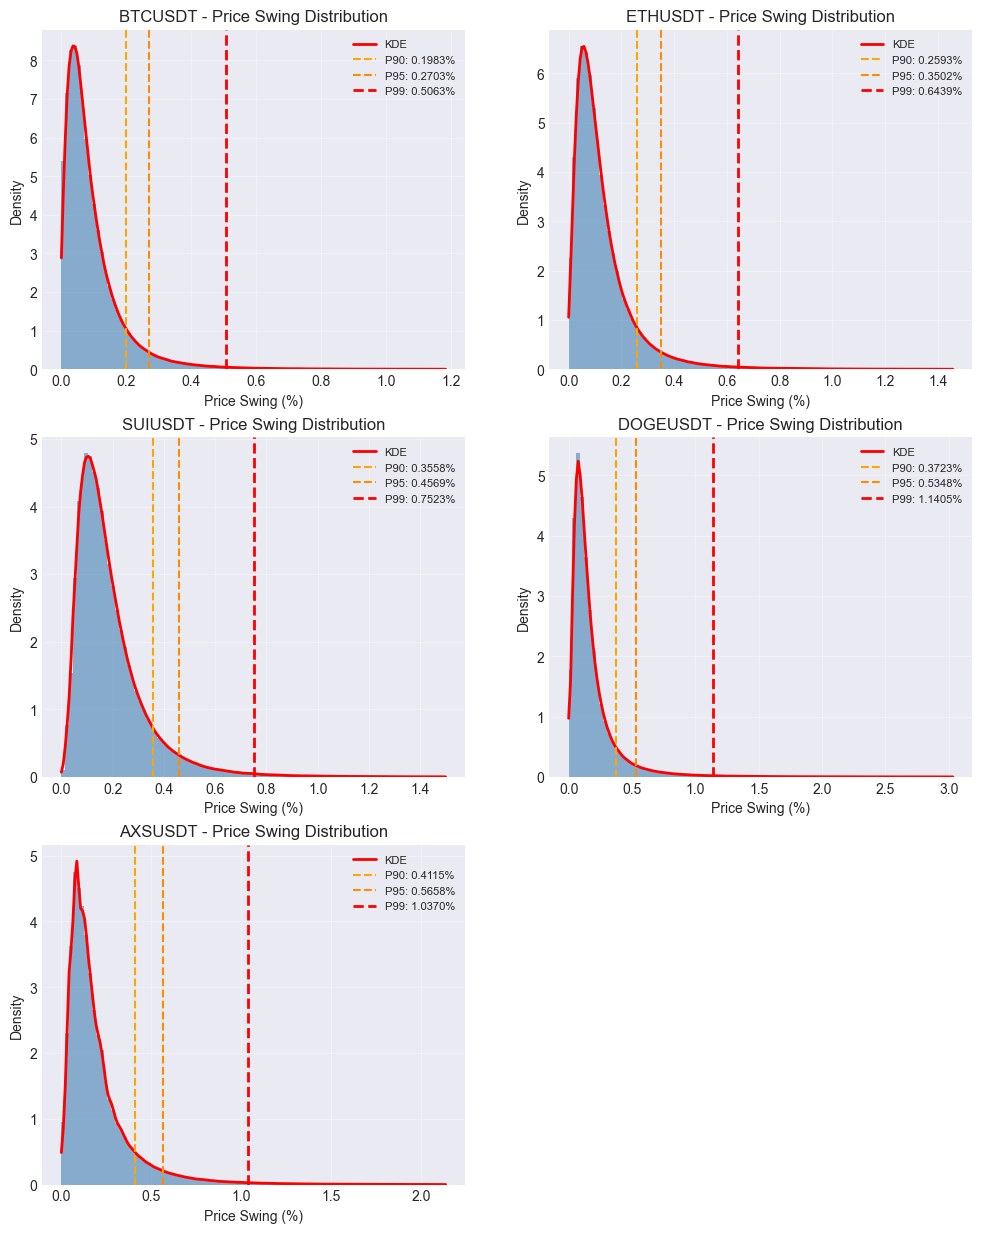

In [9]:
# Visualize swing distributions
# Calculate grid layout dynamically based on number of symbols with data
symbols_with_data = [s for s in SYMBOLS if s in swing_data]
n_symbols = len(symbols_with_data)
nrows, ncols = calculate_subplot_grid(n_symbols)
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))

# Handle both single subplot and multiple subplots
if n_symbols == 1:
    axes = [axes]
else:
    axes = axes.flatten() if n_symbols > 1 else [axes]

for idx, symbol in enumerate(symbols_with_data):
    ax = axes[idx]
    swings = swing_data[symbol]['swing_pct']
    
    # Plot histogram with KDE
    swings_clean = swings[swings < swings.quantile(0.999)]  # Remove extreme outliers for visualization
    ax.hist(swings_clean, bins=100, density=True, alpha=0.6, color='steelblue', edgecolor='none')
    
    # Add KDE
    from scipy.stats import gaussian_kde
    try:
        kde = gaussian_kde(swings_clean.dropna())
        x_range = np.linspace(swings_clean.min(), swings_clean.max(), 200)
        ax.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
    except:
        pass
    
    # Add percentile markers
    p90 = swings.quantile(0.90)
    p95 = swings.quantile(0.95)
    p99 = swings.quantile(0.99)
    ax.axvline(p90, color='orange', linestyle='--', linewidth=1.5, label=f'P90: {p90:.4f}%')
    ax.axvline(p95, color='darkorange', linestyle='--', linewidth=1.5, label=f'P95: {p95:.4f}%')
    ax.axvline(p99, color='red', linestyle='--', linewidth=2, label=f'P99: {p99:.4f}%')
    
    ax.set_xlabel('Price Swing (%)')
    ax.set_ylabel('Density')
    ax.set_title(f'{symbol} - Price Swing Distribution')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Remove empty subplots if any
total_subplots = nrows * ncols
for idx in range(n_symbols, total_subplots):
    fig.delaxes(axes[idx])

plt.show()


#### Extremem Price Swing

In [10]:
for symbol in SYMBOLS:
    if symbol in swing_data:
        df = swing_data[symbol].copy()
        df['quote_volume'] = df['close'] * df['volume']
        top_swings = df.nlargest(10, 'swing_pct')[['swing_pct', 'low', 'high', 'quote_volume']]
        top_swings = top_swings.reset_index()
        top_swings.columns = ['Timestamp', 'Swing%', 'Low Price', 'High Price', 'Volume']
        top_swings['Timestamp'] = top_swings['Timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
        top_swings['Symbol'] = symbol
        
        print(f"\n{symbol}:")
        display(top_swings[['Timestamp', 'Symbol', 'Swing%', 'Low Price', 'High Price', 'Volume']].style.format({
            'Swing%': '{:.2f}',
            'Low Price': '{:.6f}',
            'High Price': '{:.6f}',
            'Volume': '${:,.0f}'
        }))


BTCUSDT:


,Timestamp,Symbol,Swing%,Low Price,High Price,Volume
0,2021-07-26 01:01:00,BTCUSDT,24.92,37542.140000,48168.600000,"$759,947,646"
1,2020-03-12 10:48:00,BTCUSDT,17.57,5199.170000,6198.000000,"$34,735,452"
2,2021-04-18 03:35:00,BTCUSDT,16.18,50050.000000,58839.060000,"$390,920,107"
3,2021-05-19 13:22:00,BTCUSDT,13.25,32000.000000,36533.000000,"$33,131,024"
4,2020-03-12 11:02:00,BTCUSDT,12.43,5740.000000,6500.000000,"$23,397,664"
5,2021-05-19 13:20:00,BTCUSDT,11.35,32135.050000,35999.000000,"$35,293,568"
6,2021-05-19 13:29:00,BTCUSDT,11.10,32307.820000,36100.000000,"$26,883,510"
7,2021-05-19 13:10:00,BTCUSDT,11.05,28688.000000,32040.600000,"$152,795,439"
8,2020-03-13 02:31:00,BTCUSDT,11.03,4199.170000,4689.070000,"$16,386,034"
9,2021-07-26 01:02:00,BTCUSDT,10.90,39457.200000,44000.000000,"$357,798,541"



ETHUSDT:


,Timestamp,Symbol,Swing%,Low Price,High Price,Volume
0,2020-03-13 02:39:00,ETHUSDT,108.81,108.800000,323.000000,"$3,501,801"
1,2021-05-19 13:11:00,ETHUSDT,39.59,1450.000000,2154.390000,"$82,418,822"
2,2021-05-19 13:10:00,ETHUSDT,28.89,1400.730000,1870.000000,"$82,848,609"
3,2021-05-19 13:09:00,ETHUSDT,25.65,1550.000000,2003.250000,"$68,934,124"
4,2021-05-19 13:34:00,ETHUSDT,21.19,2118.000000,2618.000000,"$36,515,814"
5,2021-05-19 13:35:00,ETHUSDT,21.09,2120.220000,2618.000000,"$17,808,476"
6,2020-08-02 04:41:00,ETHUSDT,16.72,302.000000,356.960000,"$42,710,770"
7,2021-05-19 13:15:00,ETHUSDT,14.93,2055.000000,2385.980000,"$13,654,188"
8,2021-05-19 13:13:00,ETHUSDT,14.80,1950.000000,2261.000000,"$47,061,987"
9,2021-05-19 13:14:00,ETHUSDT,14.72,2055.000000,2381.000000,"$43,970,278"



SUIUSDT:


,Timestamp,Symbol,Swing%,Low Price,High Price,Volume
0,2025-10-10 21:21:00,SUIUSDT,75.79,0.566900,1.209600,"$11,205,487"
1,2025-10-10 21:19:00,SUIUSDT,56.36,0.943900,1.658400,"$10,408,298"
2,2025-10-10 21:20:00,SUIUSDT,38.65,0.680300,1.001300,"$8,110,987"
3,2025-10-10 21:22:00,SUIUSDT,31.90,1.031600,1.419200,"$10,196,073"
4,2025-10-10 21:23:00,SUIUSDT,27.44,1.326700,1.745600,"$9,018,469"
5,2025-10-10 21:18:00,SUIUSDT,26.08,1.645800,2.136100,"$17,540,201"
6,2025-10-10 21:17:00,SUIUSDT,17.88,1.932500,2.310800,"$22,898,259"
7,2025-10-10 21:24:00,SUIUSDT,17.87,1.342900,1.605700,"$7,680,042"
8,2024-04-12 18:35:00,SUIUSDT,15.20,1.030000,1.199100,"$7,200,397"
9,2025-10-10 21:25:00,SUIUSDT,14.99,1.539800,1.788900,"$9,063,601"



DOGEUSDT:


,Timestamp,Symbol,Swing%,Low Price,High Price,Volume
0,2021-05-19 13:01:00,DOGEUSDT,34.70,0.204590,0.289470,"$6,879,238"
1,2025-10-10 21:18:00,DOGEUSDT,34.25,0.120310,0.169460,"$49,738,644"
2,2025-10-10 21:21:00,DOGEUSDT,34.12,0.087870,0.123600,"$27,767,264"
3,2025-10-10 21:19:00,DOGEUSDT,32.55,0.102800,0.142350,"$46,625,967"
4,2025-10-10 21:20:00,DOGEUSDT,30.50,0.083850,0.113750,"$23,604,017"
5,2021-01-29 03:21:00,DOGEUSDT,28.21,0.066900,0.088700,"$40,151,007"
6,2021-01-29 06:48:00,DOGEUSDT,25.13,0.042000,0.054000,"$36,679,467"
7,2021-05-19 12:55:00,DOGEUSDT,24.08,0.204360,0.260000,"$12,837,829"
8,2021-05-19 13:03:00,DOGEUSDT,20.50,0.225940,0.277340,"$5,867,204"
9,2021-01-29 03:25:00,DOGEUSDT,19.58,0.063914,0.077739,"$21,581,319"



AXSUSDT:


,Timestamp,Symbol,Swing%,Low Price,High Price,Volume
0,2022-11-13 13:40:00,AXSUSDT,57.17,7.533000,13.343000,"$30,682,229"
1,2022-11-13 13:41:00,AXSUSDT,46.15,8.325000,13.207000,"$9,659,653"
2,2021-05-19 13:13:00,AXSUSDT,28.27,2.201000,2.920000,"$45,588"
3,2021-05-19 13:45:00,AXSUSDT,26.11,3.281000,4.260000,"$20,271"
4,2021-05-19 13:12:00,AXSUSDT,24.07,2.201000,2.800000,"$45,996"
5,2025-10-10 21:18:00,AXSUSDT,24.00,1.187000,1.509000,"$624,979"
6,2021-05-19 13:15:00,AXSUSDT,23.16,2.425000,3.057000,"$15,402"
7,2021-05-19 13:11:00,AXSUSDT,20.66,2.270000,2.791000,"$41,665"
8,2021-05-19 13:08:00,AXSUSDT,20.58,2.573000,3.161000,"$48,202"
9,2022-11-13 13:42:00,AXSUSDT,20.40,8.521000,10.449000,"$6,394,744"


## 3. Volatility Estimation
### Overview

#### Close-to-close Returns

Traditional volatility estimation uses the standard deviation of close-to-close returns, calculated as:

$$\sigma^2_{\text{Close}} = \frac{1}{n-1} \sum_{i=1}^{n} \left( \ln\left(\frac{C_i}{C_{i-1}}\right) \right)^2$$

where $C_i$ is the closing price at time $i$.

This estimator has a fundamental flaw for risk management: **it completely ignores the intraday path that price took during each period**.
- Consider a 1-minute candle where price drops 5% intraday (perhaps triggering liquidations or stop-losses) but closes exactly where it opened.
- The close-to-close return is zero, contributing zero to measured volatility, yet traders holding leveraged positions during that minute experienced significant drawdown and potential liquidation risk.

#### The Parkinson Volatility Estimator

Parkinson Volatility is an estimator that uses only the High-Low range to estimate variance. The key insight is that if prices follow a Brownian motion (the standard assumption in quantitative finance), the expected squared range provides information about the underlying volatility.

For each period $t$, the Parkinson variance is:

$$\sigma^2_{\text{Parkinson},t} = \frac{1}{4 \ln(2)} \left( \ln\left(\frac{H_t}{L_t}\right) \right)^2$$

where:
- $H_t$ is the high price
- $L_t$ is the low price
- $\frac{1}{4\ln(2)} \approx 0.361$ derives from the distribution of the range of Brownian motion. 

The Parkinson estimator is particularly appropriate for the Price Band application because it explicitly captures "wicks". A manipulation attempt that briefly spikes the price will show up clearly in the H-L range even if the close quickly recovers. The estimator assumes continuous trading with no opening gaps, which holds well for cryptocurrency markets that trade 24/7/365.

#### The Garman-Klass Volatility Estimator

The Garman-Klass (GK) Volatility extends the range-based approach of Parkinson Volatility by incorporating Open and Close data. The Garman-Klass variance for period $t$ is:

$$\sigma^2_{\text{GK},t} = 0.5 \left( \ln\left(\frac{H_t}{L_t}\right) \right)^2 - (2\ln(2) - 1) \left( \ln\left(\frac{C_t}{O_t}\right) \right)^2$$

where the first term captures the range contribution (similar to Parkinson) and the second term adds information from the open-to-close movement. The constant $2\ln(2) - 1 \approx 0.386$ arises from minimizing the variance of the estimator.

### Volatility Implementation

We now implement the three volatility estimators (Close-to-Close, Parkinson, Garman-Klass) and compare their behavior across assets and time periods.

In [11]:
def calculate_close_to_close_volatility(df, window=60):
    """Calculate close-to-close volatility using log returns."""
    log_returns = np.log(df['close'] / df['close'].shift(1))
    volatility = log_returns.rolling(window=window).std()
    return volatility

def calculate_parkinson_volatility(df, window=60):
    """Calculate Parkinson volatility estimator."""
    # Parkinson variance for each period
    hl_ratio = np.log(df['high'] / df['low'])
    parkinson_var = (1 / (4 * np.log(2))) * (hl_ratio ** 2)
    # Rolling average of variance, then take square root
    volatility = np.sqrt(parkinson_var.rolling(window=window).mean())
    return volatility

def calculate_garman_klass_volatility(df, window=60):
    """Calculate Garman-Klass volatility estimator."""
    hl_ratio = np.log(df['high'] / df['low'])
    co_ratio = np.log(df['close'] / df['open'])
    
    # Garman-Klass variance for each period
    gk_var = 0.5 * (hl_ratio ** 2) - (2 * np.log(2) - 1) * (co_ratio ** 2)
    # Rolling average of variance, then take square root
    volatility = np.sqrt(gk_var.rolling(window=window).mean())
    return volatility

def annualize_volatility(vol_minute):
    """Convert per-minute volatility to annualized volatility."""
    minutes_per_year = 365.25 * 24 * 60
    return vol_minute * np.sqrt(minutes_per_year)

# Calculate volatilities for all symbols
volatility_results = {}
window_size = 60  # 60-minute window for balanced responsiveness

for symbol in SYMBOLS:
    if symbol in klines:
        df = klines[symbol].copy()
        
        # Calculate all three estimators
        df['vol_close'] = calculate_close_to_close_volatility(df, window=window_size)
        df['vol_parkinson'] = calculate_parkinson_volatility(df, window=window_size)
        df['vol_gk'] = calculate_garman_klass_volatility(df, window=window_size)
        
        # Annualize
        df['vol_close_annual'] = annualize_volatility(df['vol_close']) * 100  # Convert to percentage
        df['vol_parkinson_annual'] = annualize_volatility(df['vol_parkinson']) * 100
        df['vol_gk_annual'] = annualize_volatility(df['vol_gk']) * 100
        
        volatility_results[symbol] = df

print("✓ Volatility calculations completed for all symbols")

✓ Volatility calculations completed for all symbols


#### Volatility Time Series Visualization

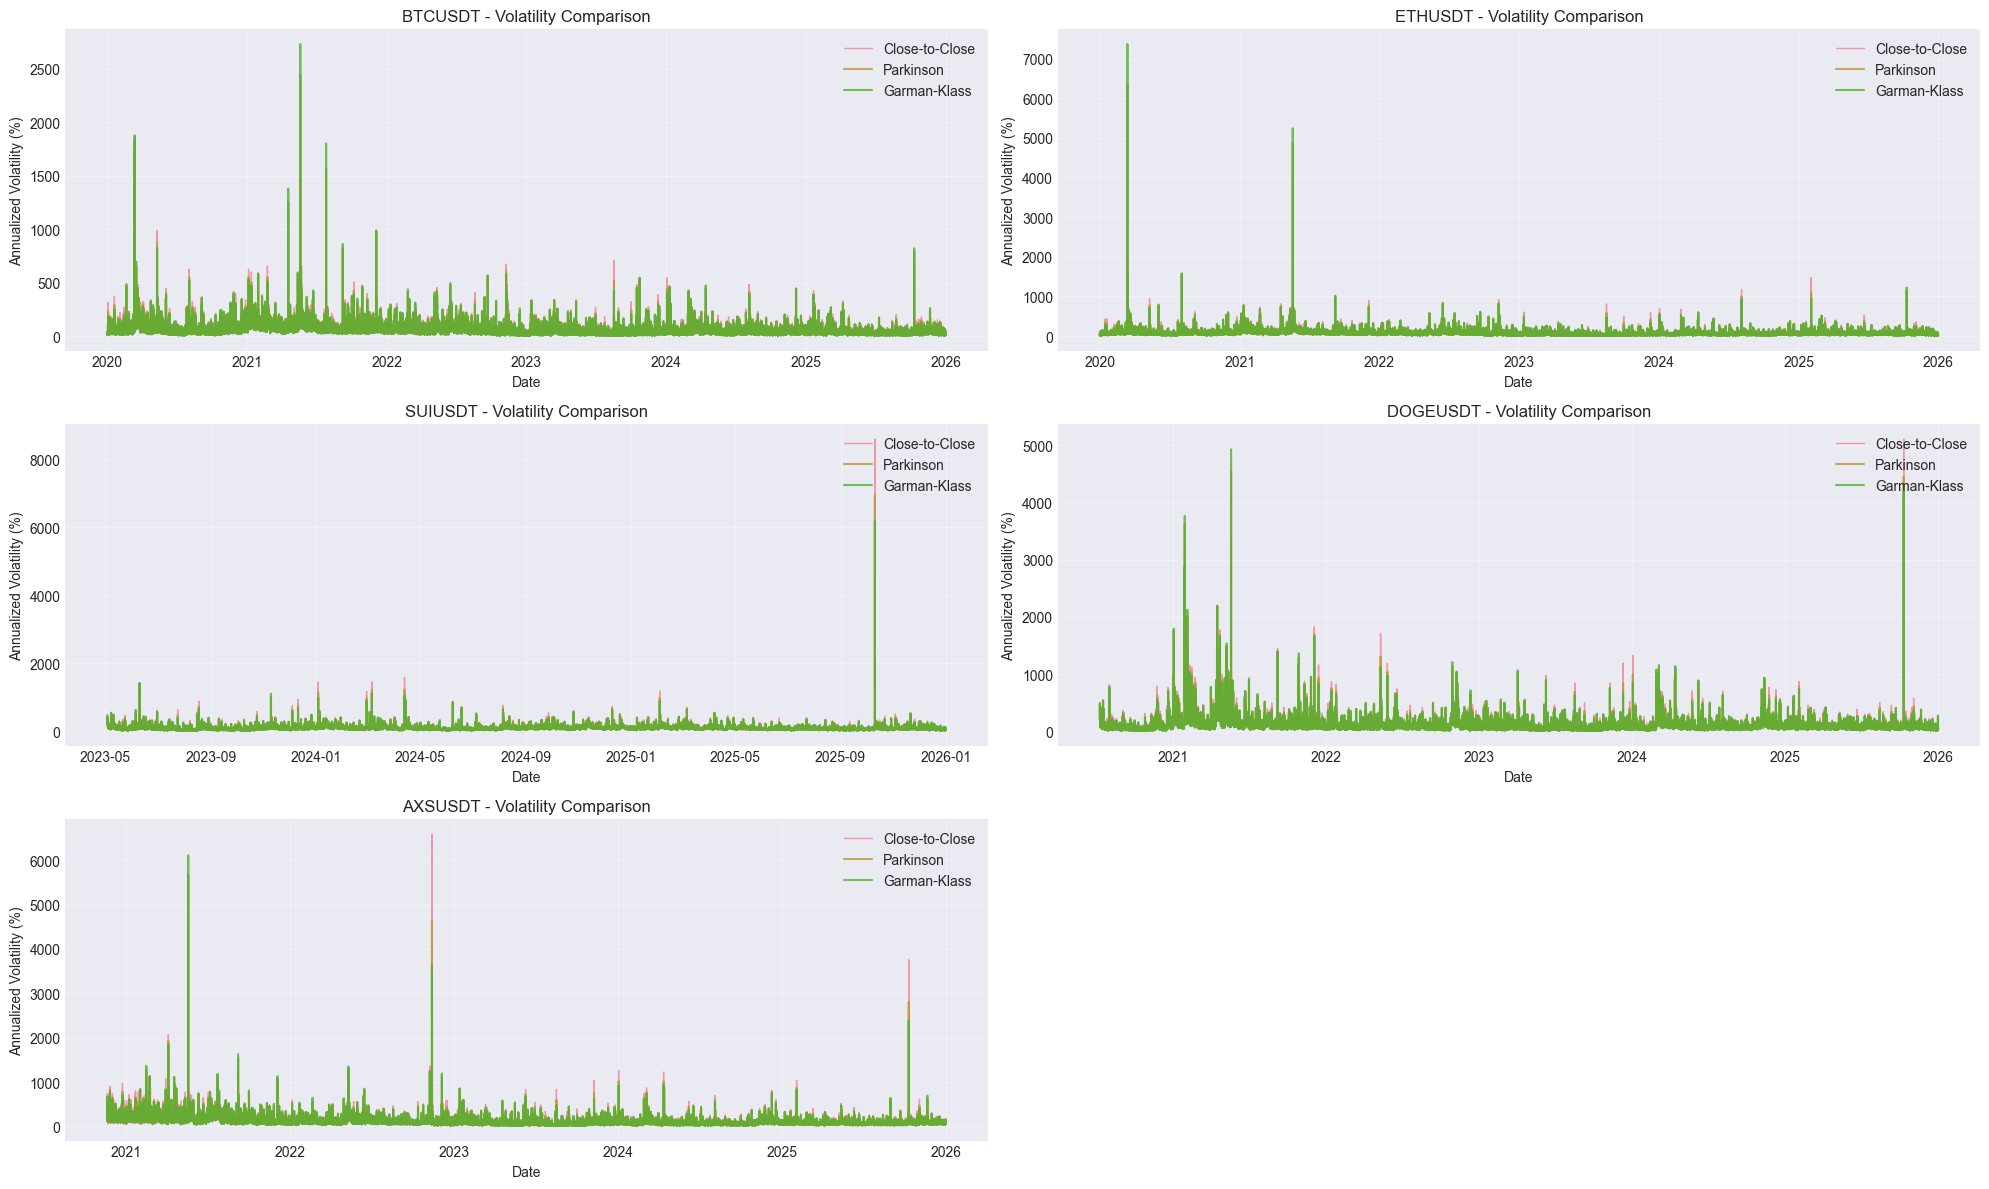

In [12]:
# Plot volatility time series for each symbol
# Calculate grid layout dynamically based on number of symbols with data
symbols_with_data = [s for s in SYMBOLS if s in volatility_results]
n_symbols = len(symbols_with_data)
nrows, ncols = calculate_subplot_grid(n_symbols)
fig, axes = plt.subplots(nrows, ncols, figsize=(10*ncols, 4*nrows))

# Handle both single subplot and multiple subplots
if n_symbols == 1:
    axes = [axes]
else:
    axes = axes.flatten() if n_symbols > 1 else [axes]

for idx, symbol in enumerate(symbols_with_data):
    ax = axes[idx]
    df = volatility_results[symbol]
    
    # Subsample for performance (plot every 60th point for daily granularity)
    df_plot = df[::60]
    
    ax.plot(df_plot.index, df_plot['vol_close_annual'], label='Close-to-Close', alpha=0.7, linewidth=1)
    ax.plot(df_plot.index, df_plot['vol_parkinson_annual'], label='Parkinson', alpha=0.8, linewidth=1.5)
    ax.plot(df_plot.index, df_plot['vol_gk_annual'], label='Garman-Klass', alpha=0.8, linewidth=1.5)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Annualized Volatility (%)')
    ax.set_title(f'{symbol} - Volatility Comparison')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

# Remove empty subplots if any
total_subplots = nrows * ncols
for idx in range(n_symbols, total_subplots):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig('volatility_timeseries.png', dpi=150, bbox_inches='tight')
plt.show()

#### Annualized Volatility Summary

In [13]:
from IPython.display import HTML, display

# Calculate summary statistics
vol_summary = []
for symbol in SYMBOLS:
    if symbol in volatility_results:
        df = volatility_results[symbol]
        
        # Calculate base statistics
        mean_val = df['vol_parkinson_annual'].mean()
        median_val = df['vol_parkinson_annual'].median()
        p95_val = df['vol_parkinson_annual'].quantile(0.95)
        max_val = df['vol_parkinson_annual'].max()
        
        summary = {
            'Symbol': symbol,
            'Close-Close (Mean)': df['vol_close_annual'].mean(),
            'Parkinson (Mean)': mean_val,
            'Garman-Klass (Mean)': df['vol_gk_annual'].mean(),
            'Parkinson (Median)': median_val,
            'Parkinson (P95)': p95_val,
            'Parkinson (Max)': max_val,
            'Parkinson (P95/Median)': p95_val / median_val,
            'Parkinson (Max/P95)': max_val / p95_val
        }
        vol_summary.append(summary)

vol_summary_df = pd.DataFrame(vol_summary)
display(HTML('<h3 style="text-align: center; margin-top: 20px; margin-bottom: 10px; font-weight: bold;">ANNUALIZED VOLATILITY SUMMARY (%)</h3>'))
display(vol_summary_df.style.format({
    'Close-Close (Mean)': '{:.2f}',
    'Parkinson (Mean)': '{:.2f}',
    'Garman-Klass (Mean)': '{:.2f}',
    'Parkinson (Median)': '{:.2f}',
    'Parkinson (P95)': '{:.2f}',
    'Parkinson (Max)': '{:.2f}',
    'Parkinson (P95/Median)': '{:.2f}x',
    'Parkinson (Max/P95)': '{:.2f}x'
}))

,Symbol,Close-Close (Mean),Parkinson (Mean),Garman-Klass (Mean),Parkinson (Median),Parkinson (P95),Parkinson (Max),Parkinson (P95/Median),Parkinson (Max/P95)
0,BTCUSDT,52.14,49.18,47.82,38.45,118.12,2575.33,3.07x,21.80x
1,ETHUSDT,68.36,65.52,64.25,53.12,148.98,6351.55,2.80x,42.63x
2,SUIUSDT,99.71,94.73,92.68,82.20,188.87,6976.28,2.30x,36.94x
3,DOGEUSDT,96.83,93.84,92.71,67.30,238.01,5096.89,3.54x,21.41x
4,AXSUSDT,108.73,102.39,100.14,77.54,253.78,5829.68,3.27x,22.97x


## 4. Liquidity Metrics

While volatility measures how much prices move, liquidity measures how easily you can trade without moving the price.

**Key Question**: If we need to liquidate a large position, how much will the price move against us?

We use the **Amihud Illiquidity Ratio** to quantify this.

### The Amihud Illiquidity Ratio

The Amihud ILLIQ ratio measures price impact per dollar traded:

$$\text{ILLIQ}_{24h} = \frac{|R_{24h}|}{\text{DollarVolume}_{24h}}$$

where $R_{24h}$ is the daily return and $\text{DollarVolume}_{24h}$ is the total dollar volume traded that day.

**Interpretation:**
- **Higher ILLIQ** = More price impact per dollar = Less liquid
- **Lower ILLIQ** = Less price impact per dollar = More liquid

We calculate rolling averages over 24h and 7d windows for real-time monitoring.

### Liquidity Implementation

In [14]:
# Import liquidity calculation functions from src module
import sys
from pathlib import Path

src_path = Path.cwd().parent.parent / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path.resolve()))

# Import Amihud ILLIQ functions
from liquidity_metrics import (
    calculate_amihud_illiq,
    calculate_rolling_illiq,
    classify_liquidity_tier_illiq,
)

print("✓ Imported liquidity metrics functions from src/liquidity_metrics.py")
print("\nUsing Amihud Illiquidity Ratio (2002)")
print("  - calculate_amihud_illiq()")
print("  - calculate_rolling_illiq()")

# ============================================================================
# CALCULATE LIQUIDITY METRICS FOR ALL SYMBOLS
# ============================================================================

liquidity_results = {}

print("\n" + "=" * 70)
print("LIQUIDITY METRICS CALCULATION")
print("=" * 70)
print("\nMethod: Amihud Illiquidity Ratio")
print("  - ILLIQ = |Daily Return| / Daily Dollar Volume")
print("  - Rolling windows: 24h, 7d")
print("=" * 70)

for symbol in SYMBOLS:
    if symbol in klines:
        print(f"\n{symbol}:")
        
        df = klines[symbol].copy()
        
        # Calculate Amihud ILLIQ
        print("  Calculating Amihud ILLIQ...")
        df_with_liquidity = calculate_rolling_illiq(df, windows=['24h', '7d'])
        liquidity_results[symbol] = df_with_liquidity
        
        # Print summary statistics
        illiq_mean = df_with_liquidity['ILLIQ_24h'].mean()
        illiq_median = df_with_liquidity['ILLIQ_24h'].median()
        print(f"  ILLIQ_24h: Mean = {illiq_mean:.2e}, Median = {illiq_median:.2e}")


✓ Imported liquidity metrics functions from src/liquidity_metrics.py

Using Amihud Illiquidity Ratio (2002)
  - calculate_amihud_illiq()
  - calculate_rolling_illiq()

LIQUIDITY METRICS CALCULATION

Method: Amihud Illiquidity Ratio
  - ILLIQ = |Daily Return| / Daily Dollar Volume
  - Rolling windows: 24h, 7d

BTCUSDT:
  Calculating Amihud ILLIQ...
  ILLIQ_24h: Mean = 6.05e-12, Median = 3.18e-12

ETHUSDT:
  Calculating Amihud ILLIQ...
  ILLIQ_24h: Mean = 4.05e-11, Median = 7.99e-12

SUIUSDT:
  Calculating Amihud ILLIQ...
  ILLIQ_24h: Mean = 3.17e-10, Median = 1.98e-10

DOGEUSDT:
  Calculating Amihud ILLIQ...
  ILLIQ_24h: Mean = 1.21e-09, Median = 1.23e-10

AXSUSDT:
  Calculating Amihud ILLIQ...
  ILLIQ_24h: Mean = 2.91e-09, Median = 1.18e-09


### Liquidity Time Series Visualization

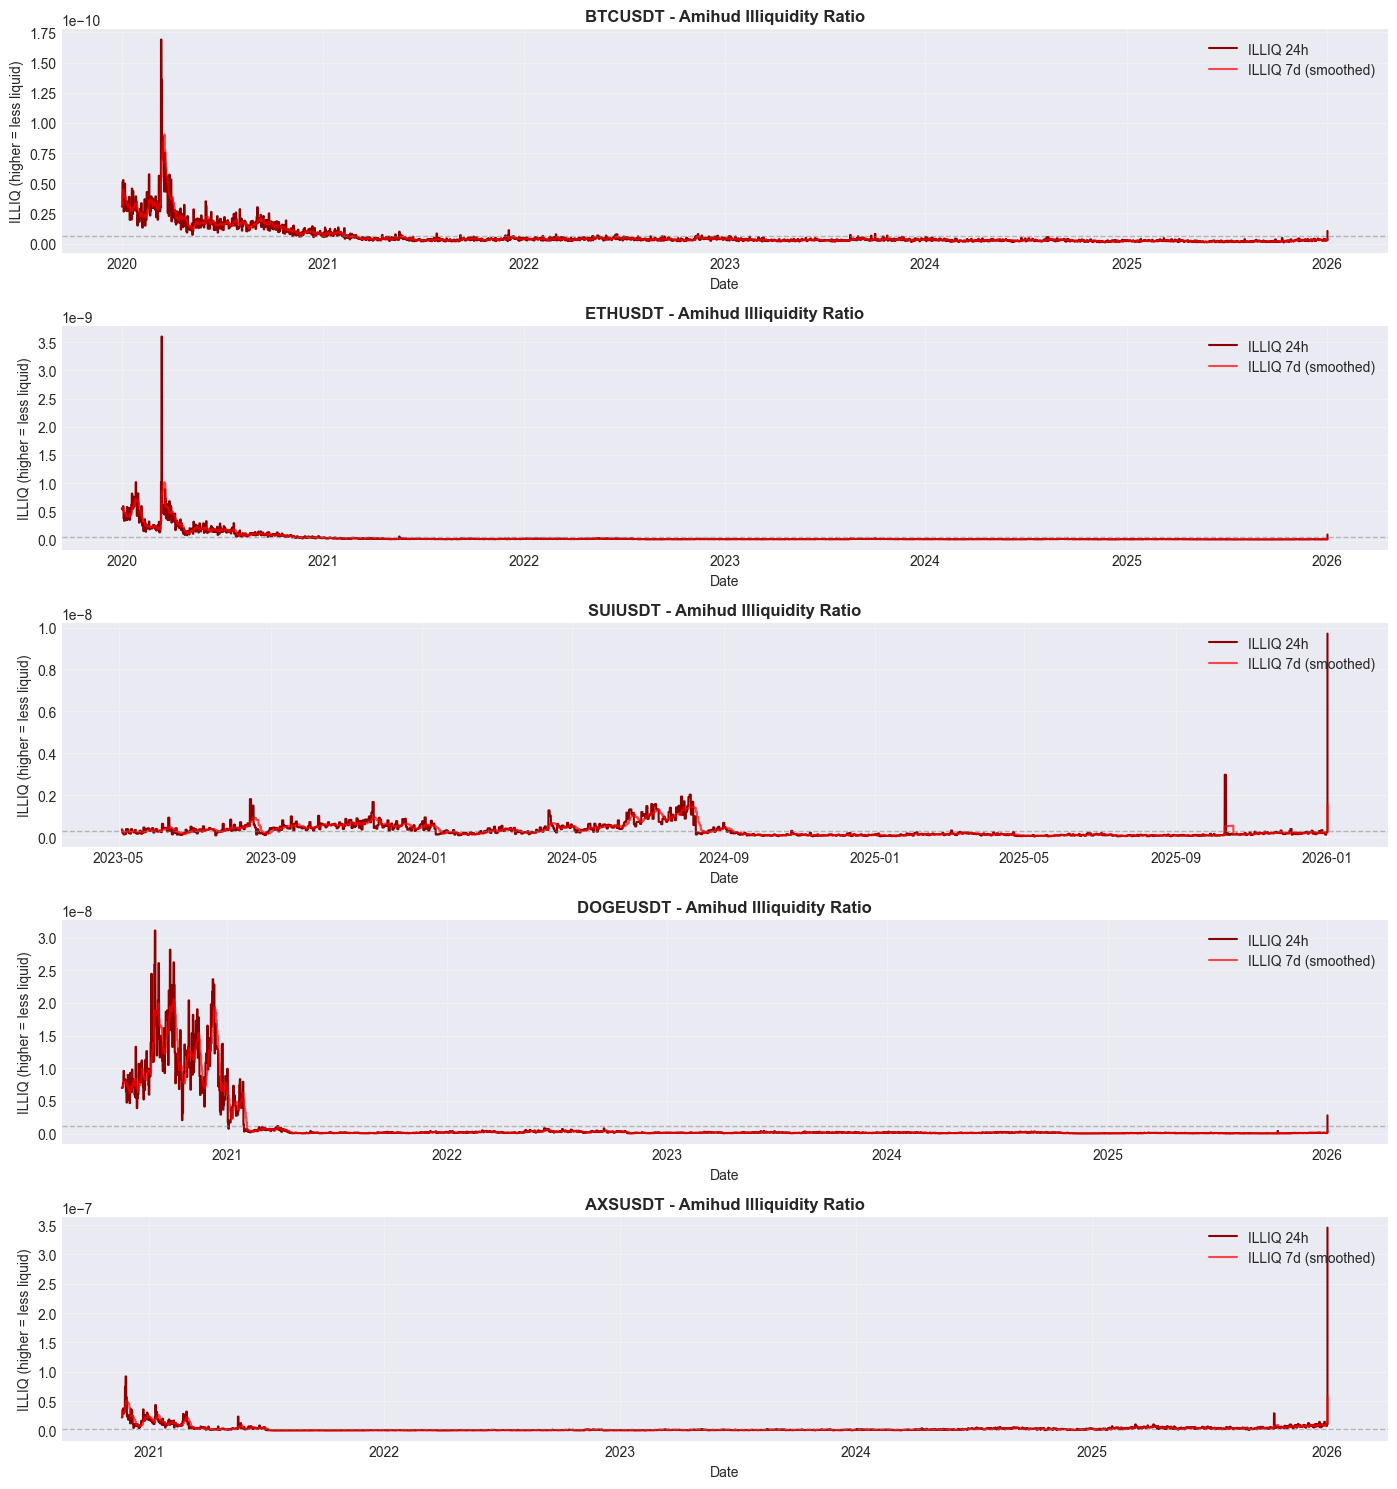

In [15]:
import matplotlib.pyplot as plt
from pathlib import Path

# Create output directory if it doesn't exist
output_dir = Path('notes/oi_risk')
output_dir.mkdir(parents=True, exist_ok=True)

# Create time series plots for ILLIQ metrics
fig, axes = plt.subplots(len(SYMBOLS), 1, figsize=(14, 3 * len(SYMBOLS)))
if len(SYMBOLS) == 1:
    axes = [axes]

for idx, symbol in enumerate(SYMBOLS):
    ax = axes[idx]
    df = liquidity_results[symbol]
    
    # Plot ILLIQ time series
    ax.plot(df.index, df['ILLIQ_24h'], label='ILLIQ 24h', linewidth=1.5, color='darkred')
    ax.plot(df.index, df['ILLIQ_7d'], label='ILLIQ 7d (smoothed)', linewidth=1.5, color='red', alpha=0.7)
    
    ax.set_title(f'{symbol} - Amihud Illiquidity Ratio', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('ILLIQ (higher = less liquid)')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Add horizontal line for mean
    mean_illiq = df['ILLIQ_24h'].mean()
    ax.axhline(y=mean_illiq, color='gray', linestyle='--', linewidth=1, alpha=0.5, label=f'Mean: {mean_illiq:.2e}')

plt.tight_layout()

# Save with proper path
plt.show()


### Liquidity Summary Statistics

We calculate summary statistics for 24-hour ILLIQ, which serves as the primary input to OI limit calculations.

In [16]:
# Calculate summary statistics
summary_list = []

for symbol, df in liquidity_results.items():
    summary = {
        'Symbol': symbol,
        'ILLIQ_24h_Mean': df['ILLIQ_24h'].mean(),
        'ILLIQ_24h_Median': df['ILLIQ_24h'].median(),
        'ILLIQ_24h_P95': df['ILLIQ_24h'].quantile(0.95),
        'ILLIQ_7d_Mean': df['ILLIQ_7d'].mean(),
    }
    summary_list.append(summary)

liquidity_summary_df = pd.DataFrame(summary_list)

from IPython.display import HTML, display
display(HTML('<h3 style="text-align: left; margin-left: 120px;margin-top: 20px; margin-bottom: 10px; font-weight: bold;">LIQUIDITY SUMMARY (Amihud ILLIQ)</h3>'))
display(liquidity_summary_df.style.format({
    'ILLIQ_24h_Mean': '{:.2e}',
    'ILLIQ_24h_Median': '{:.2e}',
    'ILLIQ_24h_P95': '{:.2e}',
    'ILLIQ_7d_Mean': '{:.2e}',
}))


,Symbol,ILLIQ_24h_Mean,ILLIQ_24h_Median,ILLIQ_24h_P95,ILLIQ_7d_Mean
0,BTCUSDT,6.05e-12,3.18e-12,2.12e-11,6.10e-12
1,ETHUSDT,4.05e-11,7.99e-12,2.12e-10,4.12e-11
2,SUIUSDT,3.17e-10,1.98e-10,9.12e-10,3.18e-10
3,DOGEUSDT,1.21e-09,1.23e-10,9.60e-09,1.22e-09
4,AXSUSDT,2.91e-09,1.18e-09,1.03e-08,2.94e-09


### OI Capacity Preview

Using the OI limit formula preview from Section 6, we can estimate the Open Interest capacity for each asset using the following formula:
$$\text{OI}_\text{limit} \approx \alpha \times \frac{\text{MM}}{\text{ILLIQ}_{\text{24h}}}$$

where:
- $\alpha$: a safety factor (e.g, $\alpha = 0.4$).
- $\text{MM}$: the expected Maintenance Margin.

In [17]:
def estimate_oi_capacity_illiq(illiq_24h, alpha=0.4, maintenance_margin=0.05):
    """
    Rough estimate of OI capacity based on ILLIQ.
    
    Formula: OI_limit ≈ α × (MM / ILLIQ)
    where α is a safety factor (0.4 = conservative)
    
    This is simplified - full formula in Notebook 03.
    """
    if illiq_24h == 0 or np.isnan(illiq_24h):
        return np.nan
    return alpha * (maintenance_margin / illiq_24h)

# Apply ILLIQ-based estimation
liquidity_summary_df['OI_Capacity_Estimate'] = liquidity_summary_df['ILLIQ_24h_Mean'].apply(
    estimate_oi_capacity_illiq
)

display_cols = [
    'Symbol',
    'ILLIQ_24h_Mean',
    'OI_Capacity_Estimate'
]

display(liquidity_summary_df[display_cols].style.format({
    'ILLIQ_24h_Mean': '{:.2e}',
    'OI_Capacity_Estimate': '{:.2e}'
}))


,Symbol,ILLIQ_24h_Mean,OI_Capacity_Estimate
0,BTCUSDT,6.05e-12,3.30e+09
1,ETHUSDT,4.05e-11,4.94e+08
2,SUIUSDT,3.17e-10,6.30e+07
3,DOGEUSDT,1.21e-09,1.65e+07
4,AXSUSDT,2.91e-09,6.88e+06


## 5. Export Results

In [18]:
# Create results directory if it doesn't exist
results_dir = Path('../results')
results_dir.mkdir(parents=True, exist_ok=True)

export_data = []

for symbol in SYMBOLS:
    if symbol in volatility_results and symbol in liquidity_results:
        # Get volatility data
        vol_df = volatility_results[symbol][[
            'vol_parkinson', 'vol_parkinson_annual',
            'vol_gk', 'vol_gk_annual'
        ]].copy()

        # Get liquidity data (BOTH METHODS)
        liq_df = liquidity_results[symbol][[
            'ILLIQ_24h', 'ILLIQ_7d'
        ]].copy()

        # Get price data
        price_df = klines[symbol][['close', 'volume']].copy()

        # Combine all metrics
        combined = vol_df.join(liq_df).join(price_df)
        combined['symbol'] = symbol
        combined['timestamp'] = combined.index

        export_data.append(combined)

# Concatenate all symbols into single DataFrame
export_df = pd.concat(export_data, ignore_index=False).reset_index(drop=True)

# Save to parquet
output_path = results_dir / '01_volatility_and_liquidity.parquet'
export_df.to_parquet(output_path, index=False)


print(f"✓ Exported results to: {output_path}")
print(f"  - {len(export_df):,} records")
print(f"  - {len(export_df['symbol'].unique())} symbols")
print(f"\n📁 Full column list:")
for col in sorted(export_df.columns):
    method_marker = ""
    if col.startswith(('CS_', 'kyle_', 'dollar_')):
        method_marker = " [Method 1]"
    elif col.startswith('ILLIQ_'):
        method_marker = " [Method 2]"
    print(f"  - {col}{method_marker}")

✓ Exported results to: ../results/01_volatility_and_liquidity.parquet
  - 13,284,961 records
  - 5 symbols

📁 Full column list:
  - ILLIQ_24h [Method 2]
  - ILLIQ_7d [Method 2]
  - close
  - symbol
  - timestamp
  - vol_gk
  - vol_gk_annual
  - vol_parkinson
  - vol_parkinson_annual
  - volume
